In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
CaseName_Base = 'RTS24_mod1'
CaseName_ByStages = CaseName_Base + '_ByStages_nc'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_F = 'F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
Folder_G = 'G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.'
Folder_JF = 'J.Full_year_operational_cost\\Results\\F.'
Folder_JG = 'J.Full_year_operational_cost\\Results\\G.'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_F: "NN_LB1",
                 Folder_G: "NN_LB2",
                 Folder_K: "Hourly_inv",
                 Folder_L: "Cont_Hourly_inv",
                 Folder_JB: "OPC_fy",
                 Folder_JD: "R&D_fy",
                 Folder_JE: "OPT_LB_fy",
                 Folder_JF: "NN_LB_fy1",
                 Folder_JG: "NN_LB_fy2",
                 Folder_JK: "HI_fy",
                 Folder_JL: "CHI_fy"
                }

In [22]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df

In [30]:
#pd.read_csv('J.Full_year_operational_cost\\Results\\D.Representative_days_based_on_RES_and_Demand\\RTS24_mod1_ByStages_nc10\\3.Out\\oT_Result_NetworkUtilizationPerNode_DC_RTS24_mod1_ByStages_nc10.csv')
pd.read_csv("J.Full_year_operational_cost/Results/D./RTS24_mod1_ByStages_nc10/3.Out/oT_Result_NetworkUtilizationPerNode_DC_RTS24_mod1_ByStages_nc10.csv")

,Period,Scenario,LoadLevel,InitialNode,FinalNode,Circuit,GWh
0,2030,sc01,01-01 00:00:00+01:00,N_109,N_111,cac1,0.000000
1,2030,sc01,01-01 00:00:00+01:00,N_117,N_122,eac1,0.006320
2,2030,sc01,01-01 00:00:00+01:00,N_101,N_102,eac1,0.390488
3,2030,sc01,01-01 00:00:00+01:00,N_102,N_104,eac1,0.247591
4,2030,sc01,01-01 00:00:00+01:00,N_118,N_121,cac1,0.019454
...,...,...,...,...,...,...,...
480475,2030,sc01,12-30 23:00:00+01:00,N_118,N_121,eac1,0.008593
480476,2030,sc01,12-30 23:00:00+01:00,N_117,N_118,cac3,0.000000
480477,2030,sc01,12-30 23:00:00+01:00,N_106,N_108,cac2,0.000000
480478,2030,sc01,12-30 23:00:00+01:00,N_107,N_108,eac1,0.451407


In [24]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]

folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_JB,Folder_JD,Folder_JE,Folder_JL]
folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB]
results = ["NetworkUtilizationPerNode_DC"]

results_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

<Axes: >

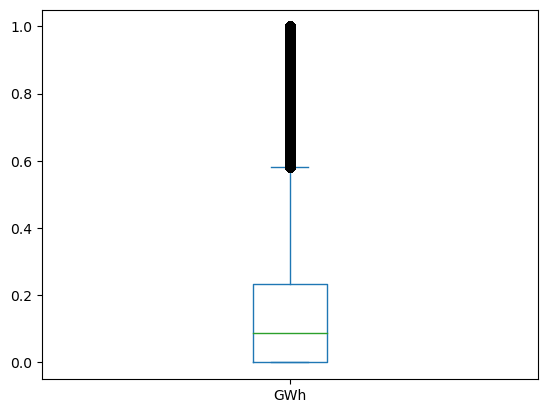

In [35]:
results_dfs["NetworkUtilizationPerNode_DC"]["A.The_full_year_MILP"][100]["GWh"].plot.box()